# Task 2: MNIST Digits Classification

In [1]:
import numpy as np
import matplotlib as plt
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
import time
from sklearn.metrics import classification_report, confusion_matrix 
import tensorflow as tf
import torch
import torchvision
import torchvision.transforms as transforms
from keras.optimizers import SGD
from torch.utils.data import random_split
import matplotlib.pyplot as plt

Using TensorFlow backend.


# Loading Dataset and Data Preprocessing

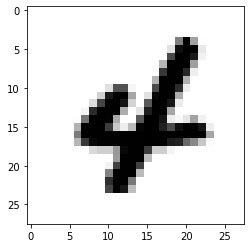

In [2]:
train_digits = torchvision.datasets.MNIST(root='./', train=True, download= True, transform= transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]))
test_digits = torchvision.datasets.MNIST(root='./', train=False, download= True, transform= transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]))
train, val = random_split(train_digits, [55000, 5000])

train_loader = torch.utils.data.DataLoader(train, batch_size=55000, shuffle=True)
val_loader = torch.utils.data.DataLoader(val, batch_size=5000, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_digits, batch_size=1000, shuffle=True)

trainImages, trainLabels = next(iter(train_loader))
testImages, testLabels = next(iter(test_loader))
validImages, validLabels = next(iter(val_loader))

trainImages = np.array(trainImages)
trainLabels = np.array(trainLabels)
testImages =np.array(testImages)
testLabels =np.array(testLabels)
validImages =np.array(validImages)
validLabels =np.array(validLabels)

plt.imshow( tf.squeeze( testImages[0]) , cmap=plt.cm.binary)

testImages = testImages.reshape((-1, 784))
trainImages = trainImages.reshape((-1, 784))
validImages =validImages.reshape((-1, 784))

trainImages = trainImages.astype('float32')
testImages = testImages.astype('float32')

# One Hot encoding of Image Labels

In [3]:
trainLabels = to_categorical(trainLabels)
testLabels =  to_categorical(testLabels)
validLabels = to_categorical(validLabels)

# Neural Network model with Numpy

In [6]:
class ANN():
    def __init__(self, epochs, lr, inp_sizes):
        self.epochs = epochs
        self.lr = lr
        self.inp_sizes = inp_sizes
        self.params = self.init_layers()

    def relu(self, x ,derivative=False):
        if derivative:
            x[x<=0] = 0
            x[x>0] = 1     
            return x
        return np.maximum(0,x)

    def sigmoid(self, x, derivative=False):
        if derivative:
            return (np.exp(-x))/((np.exp(-x)+1)**2)
        return 1/(1 + np.exp(-x))

    def softmax(self, x, derivative=False):
        exps = np.exp(x - x.max())
        if derivative:
            return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))
        return exps / np.sum(exps, axis=0)

    def init_layers(self):
        il=self.inp_sizes[0]
        l2=self.inp_sizes[1]
        l3=self.inp_sizes[2]
        l4=self.inp_sizes[3]
        ol=self.inp_sizes[4]

        params = {
            'W1':np.random.randn(l2, il) * np.sqrt(1. / l2),
            'W2':np.random.randn(l3, l2) * np.sqrt(1. / l3),
            'W3':np.random.randn(l4, l3) * np.sqrt(1. / l4),
            'W4':np.random.randn(ol, l4) * np.sqrt(1. / ol)
        }

        return params

    def full_forward(self, trainImages):
        params = self.params

        params['b0'] = trainImages

        params['Z1'] = np.dot(params["W1"], params['b0'])
        params['b1'] = self.sigmoid(params['Z1'])

        params['Z2'] = np.dot(params["W2"], params['b1'])
        params['b2'] = self.relu(params['Z2'])

        params['Z3'] = np.dot(params["W3"], params['b2'])
        params['b3'] = self.sigmoid(params['Z3'])

        params['Z4'] = np.dot(params["W4"], params['b3'])
        params['b4'] = self.softmax(params['Z4'])

        return params['b4']

    def full_backward(self, trainLabels, output):
        params = self.params
        temp_w = {}

        error = 2 * (output - trainLabels) / output.shape[0] * self.softmax(params['Z4'], derivative=True)
        temp_w['W4'] = np.outer(error, params['b3'])

        error = np.dot(params['W4'].T, error) * self.sigmoid(params['Z3'], derivative=True)
        temp_w['W3'] = np.outer(error, params['b2'])

        error = np.dot(params['W3'].T, error) * self.relu(params['Z2'], derivative=True)
        temp_w['W2'] = np.outer(error, params['b1'])

        error = np.dot(params['W2'].T, error) * self.sigmoid(params['Z1'], derivative=True)
        temp_w['W1'] = np.outer(error, params['b0'])

        return temp_w

    def sgd_update(self, update_w):
        for key, value in update_w.items():
            self.params[key] -= self.lr * value

    def acc_metrics(self, testImages, testLabels):
        predictions = []

        for x, y in zip(testImages, testLabels):
            output = self.full_forward(x)
            pred = np.argmax(output)
            predictions.append(pred == np.argmax(y))
        
        return np.mean(predictions)

    def fit(self, trainImages, trainLabels, testImages, testLabels):
        start_time = time.time()
        for iteration in range(self.epochs):
            for x,y in zip(trainImages, trainLabels):
                output = self.full_forward(x)
                update_w = self.full_backward(y, output)
                self.sgd_update(update_w)
            
            accuracy = self.acc_metrics(testImages, testLabels)
            print('Epoch: {0}, Time Spent: {1:.2f}s, Accuracy: {2:.2f}%'.format(
                iteration+1, time.time() - start_time, accuracy * 100
            ))
    def predict(self, testImages):
        predictions = []

        for x in testImages:
            prediction = self.full_forward(x)
            predictions.append(prediction)
        
        return predictions

In [7]:
model = ANN( epochs = 35, inp_sizes=[784, 128, 64, 32, 10], lr=0.001)
model.fit(trainImages, trainLabels, testImages, testLabels)

Epoch: 1, Time Spent: 24.00s, Accuracy: 21.40%
Epoch: 2, Time Spent: 47.99s, Accuracy: 25.40%
Epoch: 3, Time Spent: 71.62s, Accuracy: 33.00%
Epoch: 4, Time Spent: 95.32s, Accuracy: 39.80%
Epoch: 5, Time Spent: 119.44s, Accuracy: 45.80%
Epoch: 6, Time Spent: 143.42s, Accuracy: 50.10%
Epoch: 7, Time Spent: 168.28s, Accuracy: 56.20%
Epoch: 8, Time Spent: 191.78s, Accuracy: 61.00%
Epoch: 9, Time Spent: 216.62s, Accuracy: 65.00%
Epoch: 10, Time Spent: 241.26s, Accuracy: 67.80%
Epoch: 11, Time Spent: 265.38s, Accuracy: 69.70%
Epoch: 12, Time Spent: 289.86s, Accuracy: 72.60%
Epoch: 13, Time Spent: 314.25s, Accuracy: 74.80%
Epoch: 14, Time Spent: 338.56s, Accuracy: 77.20%
Epoch: 15, Time Spent: 362.74s, Accuracy: 78.80%
Epoch: 16, Time Spent: 387.10s, Accuracy: 79.80%
Epoch: 17, Time Spent: 411.46s, Accuracy: 81.00%
Epoch: 18, Time Spent: 435.75s, Accuracy: 82.00%
Epoch: 19, Time Spent: 460.34s, Accuracy: 82.80%
Epoch: 20, Time Spent: 484.76s, Accuracy: 83.30%
Epoch: 21, Time Spent: 508.84s, A

In [8]:
print("Accuracy: ", model.acc_metrics(testImages, testLabels))


Accuracy:  0.903


# Predictions

In [9]:
predictions = model.predict(testImages)
predictions = np.argmax(predictions, axis = 1)
print("Prediction: ", predictions[:20])
print("Actual: ",np.argmax((testLabels[:20]), axis = 1))


Prediction:  [4 7 0 3 8 4 1 9 4 3 8 7 0 8 4 1 0 1 2 6]
Actual:  [4 7 0 3 5 4 1 9 4 3 8 7 0 8 4 1 0 1 7 6]


# Classification Report and Confusion Matrix

In [10]:
print(classification_report(np.argmax(testLabels, axis = 1), predictions))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       104
           1       0.97      0.97      0.97       133
           2       0.90      0.90      0.90        92
           3       0.95      0.92      0.94       102
           4       0.85      0.90      0.87        99
           5       0.79      0.76      0.77        70
           6       0.93      0.94      0.93        81
           7       0.91      0.91      0.91        99
           8       0.86      0.88      0.87        99
           9       0.88      0.83      0.85       121

    accuracy                           0.90      1000
   macro avg       0.90      0.90      0.90      1000
weighted avg       0.90      0.90      0.90      1000



In [11]:
print(confusion_matrix(np.argmax(testLabels, axis = 1), predictions))

[[102   0   2   0   0   0   0   0   0   0]
 [  0 129   0   0   0   0   0   0   4   0]
 [  1   0  83   1   2   1   0   0   3   1]
 [  1   0   0  94   0   3   0   3   1   0]
 [  0   1   0   0  89   1   1   0   0   7]
 [  1   0   1   2   1  53   4   0   5   3]
 [  1   0   1   0   2   1  76   0   0   0]
 [  0   2   2   0   2   1   0  90   0   2]
 [  1   0   2   1   1   4   0   2  87   1]
 [  1   1   1   1   8   3   1   4   1 100]]


# Keras Model 
keras neural network implementation for comparison of results

In [12]:
keras_model = keras.Sequential([
    keras.layers.Dense(64, activation="sigmoid", input_dim=784),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(32, activation="sigmoid"),
    keras.layers.Dense(32, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [13]:
opt = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

keras_model.compile(
    optimizer="adam",
    loss = "categorical_crossentropy",
    metrics = ["accuracy"]
)

keras_model.fit(
    trainImages,
    trainLabels,
    epochs = 20,
    batch_size = 100,
    validation_data=(validImages, validLabels)
)

test_loss, test_acc = keras_model.evaluate(
    testImages,
    testLabels
)

keras_predictions = keras_model.predict(testImages)

Epoch 1/20
550/550 [==============================] - 1s 1ms/step - loss: 0.7743 - accuracy: 0.7812 - val_loss: 0.3031 - val_accuracy: 0.9148
Epoch 2/20
550/550 [==============================] - 1s 981us/step - loss: 0.2511 - accuracy: 0.9271 - val_loss: 0.2118 - val_accuracy: 0.9366
Epoch 3/20
550/550 [==============================] - 1s 984us/step - loss: 0.1788 - accuracy: 0.9468 - val_loss: 0.1828 - val_accuracy: 0.9478
Epoch 4/20
550/550 [==============================] - 1s 1ms/step - loss: 0.1449 - accuracy: 0.9567 - val_loss: 0.1481 - val_accuracy: 0.9538
Epoch 5/20
550/550 [==============================] - 1s 1ms/step - loss: 0.1200 - accuracy: 0.9645 - val_loss: 0.1518 - val_accuracy: 0.9548
Epoch 6/20
550/550 [==============================] - 1s 986us/step - loss: 0.1078 - accuracy: 0.9670 - val_loss: 0.1423 - val_accuracy: 0.9562
Epoch 7/20
550/550 [==============================] - 1s 1ms/step - loss: 0.0986 - accuracy: 0.9704 - val_loss: 0.1291 - val_accuracy: 0.9618


In [16]:
print("loss: ", test_loss, "Accuracy: ", test_acc)
print(np.argmax(keras_predictions[:20], axis=1))
print(np.argmax((testLabels[:20]), axis = 1))
print(classification_report(np.argmax(testLabels, axis = 1), np.argmax(keras_predictions, axis = 1)))

loss:  0.12904919683933258 Accuracy:  0.9639999866485596
[4 7 0 3 5 4 1 9 4 3 8 7 0 8 4 1 0 1 7 2]
[4 7 0 3 5 4 1 9 4 3 8 7 0 8 4 1 0 1 7 6]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       104
           1       0.98      0.98      0.98       133
           2       0.95      0.97      0.96        92
           3       0.96      0.95      0.96       102
           4       0.95      0.92      0.93        99
           5       0.92      0.94      0.93        70
           6       0.96      0.95      0.96        81
           7       1.00      0.96      0.98        99
           8       0.96      0.98      0.97        99
           9       0.98      0.98      0.98       121

    accuracy                           0.96      1000
   macro avg       0.96      0.96      0.96      1000
weighted avg       0.96      0.96      0.96      1000



In [17]:
print(confusion_matrix(np.argmax(testLabels, axis=1), np.argmax(keras_predictions, axis = 1)))

[[103   0   0   0   0   1   0   0   0   0]
 [  0 131   0   2   0   0   0   0   0   0]
 [  1   1  89   0   0   0   0   0   1   0]
 [  0   0   1  97   0   3   0   0   1   0]
 [  0   1   0   0  91   2   1   0   1   3]
 [  0   0   0   1   1  66   1   0   1   0]
 [  0   0   2   0   2   0  77   0   0   0]
 [  0   1   1   1   1   0   0  95   0   0]
 [  1   0   0   0   0   0   1   0  97   0]
 [  1   0   1   0   1   0   0   0   0 118]]
